# Color transfert by regularized optimal transport
In this notebook, we show how to use `Sinkhorn.py` to resolve entropy-regularized optimal tranport and apply it to color transfert:
- Initialization of variables 
    - optimal transport: images, marginals, costs, parameters
    - Sinkhorn projection: kernel, parameters
- Computations
    - Sinkorn projection
    - optimal coupling
    - resulting images
- display the results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sinkhorn import sinkhorn_debug, low_rank_Sinkhorn, sinkhorn
from builders import image2array, array2cost, image2array, transfer_color, array2image, array2matrix

## Initialization of variables:

In [2]:
N = 100 # heigth of the image (= width)
n = N^2 # number of pixels
eta = 15 # lent si plus que ~20
delta = 1e-15 # tolerance for Sinkhorn()
img1_nbr = '3'
img2_nbr = '1'
img1 = image2array('img' + img1_nbr + '_' + str(N) + '.jpg') # source image
img2 = image2array('img' + img2_nbr + '_' + str(N) + '.jpg') # target image
C, p, q = array2cost(img1, img2) # cost and coupling marginals
Kmat = np.exp(-eta * C) # kernel to project 

def K(v):
    ''' Kernel-vector matrix product'''
    return Kmat @ v
def Kt(v):
    ''' Transposed_kernel-vector matrix product'''
    return (Kmat.T) @ v

## Sinkhorn projection computation:

In [3]:
u,v,W,norm_u,norm_v,err = sinkhorn_debug(K,Kt,p,q,delta,maxtime=60)
P = u*Kmat*v.T # coupling

W = -15.131681494846816
Marginal error: 1.6376926670249453e-12


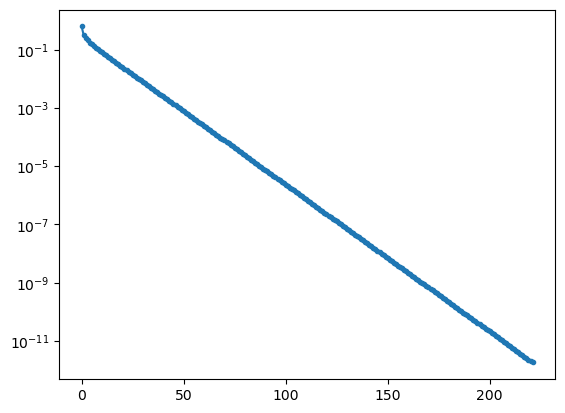

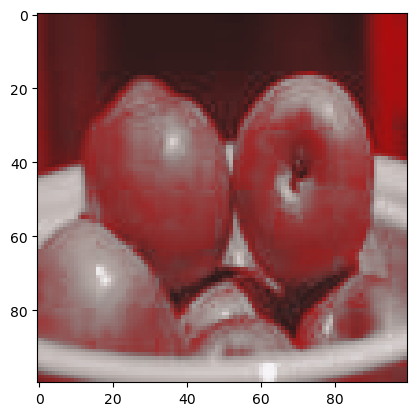

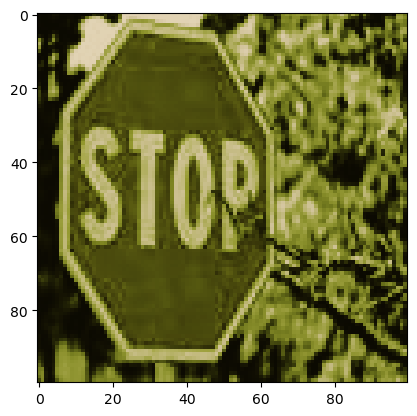

In [4]:
# Display
print("W =",W)
print("Marginal error:",err[-1])
plt.semilogy(err[:-1],".-")
# Compute resulting image
img12 = transfer_color(P,img1) # target image with source colors
img21 = transfer_color(P.T,img2) # symetry of problem
# show images:
plt.figure()
plt.imshow(array2matrix(img12),vmin=0, vmax=1)
plt.figure()
plt.imshow(array2matrix(img21),vmin=0, vmax=1)

In [5]:
# save in files
# array2image('img' + img1_nbr + img2_nbr + '.jpg', img12)
# array2image('img' + img2_nbr + img1_nbr + '.jpg', img21)

## Low rank approximation in Sinkhorn algorithm

### Studying how the rank affects the solution (compute images and compare them, compare the result in the non truncated and how far away are we )

In [6]:
rank_K_mat=np.linalg.matrix_rank(Kmat, tol=None, hermitian=False)
print(rank_K_mat, Kmat.shape)

405 (10000, 10000)


In [7]:
Kmat.shape

(10000, 10000)

In [14]:
k= 30
[u,v,W,err] = low_rank_Sinkhorn(Kmat,k,p,q,delta,maxtime=60)
P = u*Kmat*v.T # coupling

W = -15.131560359205062
Marginal error: 1.8793980586205572e-14


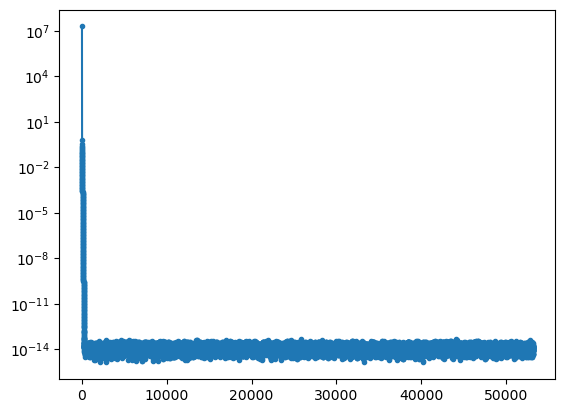

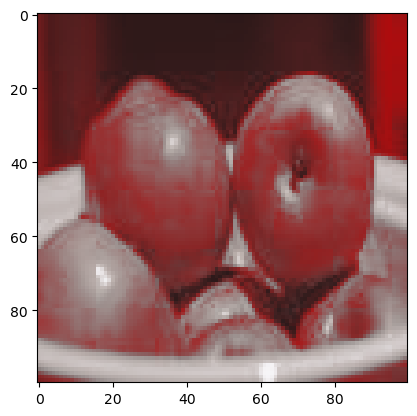

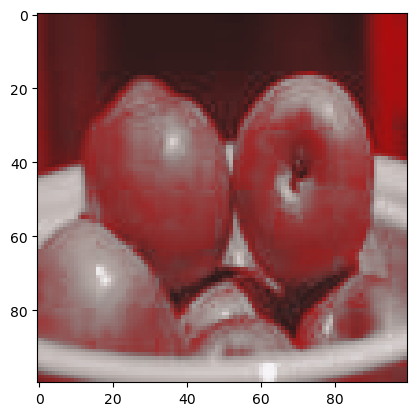

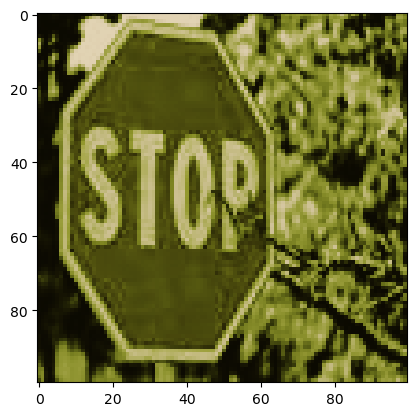

In [15]:
# Display
print("W =",W)
print("Marginal error:",err[-1])
plt.semilogy(err[:-1],".-")
# Compute resulting image
low_img12 = transfer_color(P,img1) # target image with source colors
low_img21 = transfer_color(P.T,img2) # symetry of problem
# show images:
plt.figure()
plt.imshow(array2matrix(low_img12),vmin=0, vmax=1)
plt.figure()
plt.imshow(array2matrix(img12),vmin=0, vmax=1)
plt.figure()
plt.imshow(array2matrix(low_img21),vmin=0, vmax=1)

In [23]:
# compute the speed of the algorithm depending on the approximation k

list_time=[]
list_u=[]
list_v=[]
list_W=[]
list_err_inf=[]
list_err_2=[]
[u,v,W,err] = sinkhorn(K,Kt,p,q,delta,maxtime=60)
P_full= u*Kmat*v.T

#erreur avec norme infini et norme 2

for k in [5,50]: #only up to rank of K_mat. For k>=rank_K_mat, a rank k approximation of K_mat is K_mat
    start_time=time.time()
    [low_u,low_v,W,err, P_low] = low_rank_Sinkhorn(Kmat,k,p,q,delta,maxtime=60)
    execution_time=time.time()-start_time
    list_time.append(execution_time)
    list_err_inf.append(np.linalg.norm(P_low-P_full,np.inf))
    list_err_2.append(np.linalg.norm(P_low-P_full,2))
    list_u.append(low_u)
    list_v.append(low_v)
    list_W.append(W)
    list_err.append(err)

maxtime achieved
maxtime achieved
maxtime achieved


In [24]:
list_time

[65.32687544822693, 67.63463020324707]

In [25]:
list_err_inf

[0.0002566594683584885, 6.189982726221495e-06]

In [26]:
list_err_2

[9.501630848226419e-05, 1.4060328572072457e-06]

In [27]:
list_W

[array(-9999), array(-15.13169752)]

In [28]:
list_u

[array([[6.52160917e+109],
        [8.43632235e+109],
        [1.08658379e+110],
        ...,
        [2.16130000e+109],
        [2.32462015e+109],
        [2.41375374e+109]]),
 array([[3.91208968e-07],
        [4.79736317e-07],
        [5.96240554e-07],
        ...,
        [1.69154847e-07],
        [1.82995252e-07],
        [1.90472776e-07]])]

In [29]:
list_v

[array([[2.65385302e-118],
        [2.64030337e-118],
        [2.77511729e-118],
        ...,
        [1.42434882e-116],
        [1.13854001e-116],
        [4.21227848e-117]]),
 array([[0.05034621],
        [0.0501362 ],
        [0.05237698],
        ...,
        [9.64646042],
        [3.35210605],
        [1.37611103]])]

In [22]:
np.linalg.norm(P_low-P_full,2)

0.007955833983691275

In [ ]:
ax_x=np.arange(1, rank_K_mat)
plt.plot(list_time, ax_x)
plt.plot(list_accuracy, ax_x)

In [ ]:
#stocking list_u, list_v, list_W, list_err because it took a looong time to run 
import pandas as pd

# dictionary of lists  
dict = {'list_u': list_u, 'list_v': list_v, 'list_W': list_W, 'list_err': list_err}  
df = pd.DataFrame(dict)
# saving the dataframe 
df.to_csv('low_rank_sinkhorn.csv')

In [ ]:
import os 

path_to_file='low_rank_sinkhorn.csv'

if (os.path.exists(path_to_file)):
    csvFile = pandas.read_csv('low_rank_sinkhorn.csv')
    list_u = df['list_u'].tolist()
    list_v = df['list_v'].tolist()
    list_W = df['list_W'].tolist()
    list_err = df['list_err'].tolist()
else: #create them 

### Study how much the color transfer is accelerated